# Gradient Descent Variations

In this notebook, we explore different variants of gradient descent to optimize our atmosphere.

- These variants start simple, and become more complex, in response to the task of 

In [111]:
import helper
import numpy as np
import matplotlib.pyplot as plt 
import math


First, we generate data:

- The real data, using the real atmospheric forcing
- Fake data, using our noisy atmospheric forcing

In [3]:
nr,nc = 32,32
dt = 0.01
F = 0.1


gamma = 0.5
C_control = helper.covariance_matrix_gaussian_dropoff(nr,nc)
C_known, C_error = C_control * gamma, C_control * (1-gamma)
C_ocean = C_control / 6

# Create a random model
M, _ = helper.create_random_model(nr, nc, dt, F)

# True parameters
_, x0 = helper.create_random_initial_ocean_state(nr, nc, C_ocean, num_circles=20, radius=5, values=[2,-2])


f_true, f_guess = helper.generate_first_guess_field(C_known,C_error, nr, nc)

In [4]:
num_runs = 1
F = 0.1
timesteps = 10
num_iters = 5
step_size = 0.1
sigma = 0.1 # Standard deviation of the noise in the observations


# Run the simulation under both conditions

ocean_states_real = helper.compute_2d_affine_time_evolution(x0, M, F*f_true, range(timesteps), timesteps)
ocean_states_simulated = helper.compute_2d_affine_time_evolution(x0, M, F*f_guess, range(timesteps), timesteps)


Later, we'll need observations of the real ocean state:

In [5]:
num_obs_per_timestep = 50


observations = [helper.observe(ocean_states_real[i], sigma, num_obs_per_timestep) for i in range(timesteps)]

# Place on a map

ocean_states_observed = [helper.nan_map_observations(indices_t, observations_t, nr, nc) 
                        for indices_t, observations_t in observations]


# Reshape for plotting
ocean_states_observed = [np.reshape(ocean_states_observed[i], (nr*nc,1)) for i in range(len(ocean_states_observed))]


In [13]:
# Goal: run gradient descent on the atmospheric forcing field to minimize the loss function J.

def gradient_descent_template(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                              x0, timesteps,                                   # Simulation parameters
                              ocean_states_observed, num_iters, step_size,      # Optimization parameters
                              step_compute_method, extra_params, debug=False): # Optimization method
    """
    Perform gradient descent to optimize the atmospheric forcing field. The step we take at each iteration is computed using the step_compute_method function.

    Args:
        M: Model matrix
        F: Scalar constant for forcing
        f_true: True atmospheric forcing field
        f_guess: Initial guess for the atmospheric forcing field
        x0: Initial ocean state
        timesteps: Number of timesteps
        ocean_states_observed: Observed ocean states
        num_iters: Number of iterations
        step_size: Step size for gradient descent
        C_control: Covariance matrix for the control
        C_error: Covariance matrix for the control error
        step_compute_method: Function to compute the step to take at each iteration
        extra_params: Extra parameters to pass to the step
        debug: Flag to print debug information

    Returns:
        f: Optimized atmospheric forcing field
        losses: Dictionary of losses
            ocean: Ocean loss at each iteration
            atmosphere: Atmospheric loss at each iteration
            control_adjust_mahalanobis: Mahalanobis distance for the control adjustment at each iteration
    """
    f_adjust = np.zeros((nr*nc,1))
    losses = {
        "ocean": [],
        "atmosphere": [],
        "control_adjust_mahalanobis": [],

        "Norm s": [],                 #Theoretical gradient
        "Pre-dan  expected Delta J": [], #Pre-dan expected  Delta J
        "Post-dan expected Delta J": [],             #Post-dan expected Delta J
        "Actual Delta J": [],           #Actual Delta J
        "Norm of Pre-dan step": [],    #Norm of the pre-dan step
        "Norm of Post-dan step": [],    #Norm of the post-dan step
        "$(a_i \cdot u_i)/|u_i||a_i|$": [], #Norm of the dot product between f_adjust and post-dan step
        "$s^T C@ s $": [], # Division by zero error?
        "$a_i$": [],
        "$a_i^T s$": [], 
        "$a_i^T (\delta Cs)$ Normalized": [],
    }

    for i in range(num_iters):
        f = f_guess + f_adjust
        ocean_states_simulated = helper.compute_2d_affine_time_evolution(x0, M, F*f, range(timesteps), timesteps)
        
        # Compute and store losses
        losses["ocean"].append(J(ocean_states_observed, ocean_states_simulated))
        losses["atmosphere"].append(Jt(f_true, f))
        losses["control_adjust_mahalanobis"].append(np.linalg.norm(f_adjust.T @ np.linalg.inv(C_error) @ f_adjust))

        if debug and i % 10 == 0:
            print(f"Ocean loss at iteration {i}: {losses['ocean'][-1]}")

        s = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)
        pre_dan_step = -step_size * s
        # Compute gradient and update forcing field adjustment
        #Unpack extra_params when feeding them into the function
        post_dan_step = step_compute_method(M, F, f_guess, f_adjust, C_control, C_error, 
                                   ocean_states_observed, ocean_states_simulated, step_size,
                                   *extra_params)
        

        step_gd = -step_size * s
        delta = s.T @(step_gd)
        losses["$a_i^T s$"].append( (f_adjust.T @ s)[0,0] )
        losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
        losses["$a_i$"].append( f_adjust )
        losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )

        f_adjust = f_adjust + post_dan_step
        actual_delta_J = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*(f_guess + f_adjust), range(timesteps), timesteps)) - \
                                 J(ocean_states_observed, ocean_states_simulated)


        losses["Norm s"].append( np.linalg.norm(s) )
        losses["Pre-dan  expected Delta J"].append( ( s.T @ (pre_dan_step) )[0,0] )                     #Pre-dan expected  Delta J
        losses["Post-dan expected Delta J"].append( (s.T @ post_dan_step)[0,0] )                        #Post-dan expected Delta J
        losses["Norm of Pre-dan step"].append( np.linalg.norm(pre_dan_step) )
        losses["Norm of Post-dan step"].append( np.linalg.norm(post_dan_step) )
        losses["$s^T C@ s $"].append( (s.T @ C_error @ s)[0,0] )
        losses["Actual Delta J"].append(actual_delta_J)
                                                         

    # Compute final losses
    #f = f_guess + f_adjust
    #ocean_state_simulated = helper.compute_2d_affine_time_evolution(x0, M, F*f, range(timesteps), timesteps)
    #losses["ocean"].append(J(ocean_states_observed, ocean_states_simulated))
    #losses["atmosphere"].append(Jt(f_true, f))
    #losses["control_adjust_mahalanobis"].append(np.linalg.norm(f_adjust.T @ np.linalg.inv(C_error) @ f_adjust))

    #s = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)

    #losses["Norm s"].append( np.linalg.norm(s) )
    #losses["Pre-dan  expected Delta J"].append( ( s.T @ (pre_dan_step) )[0,0] )
    #losses["Post-dan expected Delta J"].append( (s.T @ post_dan_step)[0,0] )
    #delta_J = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*(f_guess + f_adjust), range(timesteps), timesteps)) - \
    #                            J(ocean_states_observed, ocean_states_simulated)
    #losses["Actual Delta J"].append(delta_J)

    


    if debug:
        print(f"Final loss: {losses['ocean'][-1]}")

    return f_adjust, losses


def simple_gradient_step_compute(M, F, f_guess, f_adjust, C_control, C_error,      # World parameters
                                 ocean_states_observed, ocean_states_simulated, step_size ):  # Simulation + optimization
    
    return -step_size * compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated) # Just use the gradient of the loss

def simple_gradient_descent(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                            x0, timesteps,                                   # Simulation parameters
                            ocean_states_observed, num_iters, step_size,      # Optimization parameters
                            debug=False): # Optimization method
    
    return gradient_descent_template(M, F, f_true, f_guess, C_control, C_error, 
                                     x0, timesteps, 
                                     ocean_states_observed, num_iters, step_size,
                                     simple_gradient_step_compute, [], debug)




# Run gradient descent
f_adjust_simple, losses_simple = simple_gradient_descent(M, F, f_true, f_guess, C_control, C_error, 
                                                         x0, timesteps, 
                                                         ocean_states_observed, num_iters, step_size, 
                                                         debug=True)

    


        



Ocean loss at iteration 0: 48.00640893404933


C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:76: RuntimeWarning: invalid value encountered in scalar divide
  losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:78: RuntimeWarning: invalid value encountered in scalar divide
  losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )


Final loss: 38.193848626493505


# Golden Mean Line Search

In [53]:
np.argmin(np.linspace(1e-10, 1e-1, 10))

np.int64(0)

In [100]:
def baby_sweep_line_search(M, F, f_guess, f_adjust, C_control, C_error,      # World parameters
                            ocean_states_observed, ocean_states_simulated, step_size, tolerance = 1e-8):  # Simulation + optimization

    dJdf = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)

    print('beging GMLS ', alpha1, alpha2)

    nn = 100
    alphas =np.linspace(0, .1, nn)
    Js = []
    for alpha in alphas:
       # print(alpha)
        f = f_guess + f_adjust - alpha * dJdf
        Jtmp = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f, range(timesteps), timesteps))
        Js.append(Jtmp)
    
    Js = np.array(Js)
    min_i = np.argmin(Js)
    print(min_i, Js[min_i])
    return -alphas[min_i] * dJdf



def golden_mean_line_search(M, F, f_guess, f_adjust, C_control, C_error,      # World parameters
                            ocean_states_observed, ocean_states_simulated, step_size, tolerance = 1e-8):  # Simulation + optimization

    dJdf = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)

    golden_ratio = (1 + math.sqrt(5)) / 2
    inv_golden_ratio = 1 / golden_ratio

    # lower bound
    alpha1 = step_size * inv_golden_ratio  # 0.618 x step_size
    # upper bound
    alpha2 = step_size * golden_ratio # 1.618 x step_size

    print('beging GMLS ', alpha1, alpha2)

    nn = 100

    # search for the bound
    alpha_mid = step_size

    found_bound = False
    f_mid = f_guess + f_adjust - alpha_mid * dJdf
    J_mid = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_mid, range(timesteps), timesteps))
    
    alpha_low = alpha_mid * inv_golden_ratio
    f_low = f_guess + f_adjust - alpha_low * dJdf
    J_low = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_low, range(timesteps), timesteps))
    
    alpha_high = alpha_mid * golden_ratio
    f_high = f_guess + f_adjust - alpha_high * dJdf
    J_high = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_high, range(timesteps), timesteps))
    
    print('initial search for the bound', alpha_low, alpha_mid, alpha_high)
    print('initial search for the bound', J_low, J_mid, J_high)

    # do I have the bound
    if J_low < J_mid and J_low < J_high:
        found_bound= False
        search_direction = -1
    elif J_high < J_mid and J_high < J_low:
        found_bound = False
        search_direction = 1
    else:
        found_bound = True
        search_direction = 0    
        print("bound found")


    while not found_bound:
        if search_direction == -1:
            print('sliding left')

            alpha_high = alpha_mid
            J_high = J_mid
            f_high = f_mid

            alpha_mid = alpha_low
            f_mid = f_low
            J_mid = J_low

            alpha_low = alpha_low * inv_golden_ratio
            f_low = f_guess + f_adjust - alpha_low * dJdf
            J_low = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_low, range(timesteps), timesteps))

        elif search_direction == 1:
            print('sliding right')
            alpha_low = alpha_mid
            J_low= J_mid
            f_low = f_mid

            
            alpha_mid = alpha_high
            f_mid = f_high
            J_mid = J_high



            alpha_high = alpha_high* golden_ratio
            f_high = f_guess + f_adjust - alpha_high * dJdf
            J_high = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_high, range(timesteps), timesteps))
          
        print('intermediate search for the bound', alpha_low, alpha_mid, alpha_high)
        print('intermediate search for the bound', J_low, J_mid, J_high)

        if J_low < J_mid and J_low < J_high:
            print('bound to the left')
            found_bound= False
            search_direction = -1
        elif J_high < J_mid and J_high < J_low:
            print('bound to the right')
            found_bound = False
            search_direction = 1
        else:
            print('found bound')
            found_bound = True
            search_direction = 0

    return -alpha_mid * dJdf

    # while abs(alpha2 - alpha1) > tolerance:
    #     f_1 = f_guess + f_adjust - alpha1 * dJdf
    #     f_2 = f_guess + f_adjust - alpha1 * dJdf

    #     J_1 = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_1, range(timesteps), timesteps))
    #     J_2 = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_2, range(timesteps), timesteps))


    # alphas =np.linspace(0, .1, nn)
    # Js = []
    # for alpha in alphas:
    #    # print(alpha)
    #     f = f_guess + f_adjust - alpha * dJdf
    #     Jtmp = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f, range(timesteps), timesteps))
    #     Js.append(Jtmp)
    
    # Js = np.array(Js)
    # min_i = np.argmin(Js)
    # print(min_i, Js[min_i])
    # return -alphas[min_i] * dJdf

    # while abs(alpha2 - alpha1) > tolerance:
    #     f1 = f_guess + f_adjust - alpha1 * dJdf
    #     f2 = f_guess + f_adjust - alpha2 * dJdf

    #     J1 = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f1, range(timesteps), timesteps))
    #     J2 = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f2, range(timesteps), timesteps))

    #     print(f'alpha1: {alpha1}, alpha2: {alpha2}, J1: {J1}, J2: {J2}')
    #     # if lower bound is smallest
    #     if J1 < J2:
    #         print('lower bound smallest')
    #         # update upper bound to be the old lower bound
    #         alpha2 = alpha1
    #         # reduce lower bound by factor 0.618 
    #         alpha1 = alpha1 * inv_golden_ratio
    #     else: # if upper bound is smallest
    #         # update lower bound to be the old upper bound
    #         alpha1 = alpha2
    #         # increase upper bound by factor 1.618
    #         alpha2 = alpha2 * golden_ratio
    #         print('upper bound smallest')
        
    # step = -alpha1 * dJdf
    # return step


# def compute_bounds(M, F, f_guess, f_adjust, C_control, C_error,      # World parameters
#                      ocean_states_observed, ocean_states_simulated, step_size, tolerance = 1e-5):  # Simulation + optimization
#     """Compute bound of the line search using the golden ratio method. """

#     dJdf = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)

#     golden_ratio = (1 + math.sqrt(5)) / 2
#     inv_golden_ratio = 1 / golden_ratio

#     lower_bound, midpoint, upper_bound = inv_golden_ratio* step_size, step_size, golden_ratio * step_size

#     def compute_J_variations(lower_bound, midpoint, upper_bound):
#         # Compute the loss at the bounds

#         f_lower = f_guess + f_adjust - lower_bound * dJdf
#         f_midpoint = f_guess + f_adjust - midpoint * dJdf
#         f_upper = f_guess + f_adjust - upper_bound * dJdf

#         J_lower = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_lower, range(timesteps), timesteps))
#         J_midpoint = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_midpoint, range(timesteps), timesteps))
#         J_upper = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_upper, range(timesteps), timesteps))

#         return J_lower, J_midpoint, J_upper
    

#     while abs(upper_bound - lower_bound) > tolerance:
        

#         J_lower, J_midpoint, J_upper = compute_J_variations(lower_bound, midpoint, upper_bound)
#         print("Bounds:", lower_bound, midpoint, upper_bound)
#         print("J:", J_lower, J_midpoint, J_upper)

#         if J_lower < J_midpoint and J_lower < J_upper: #J_lower is smallest
#             upper_bound = midpoint
#             midpoint = lower_bound
#             lower_bound = lower_bound * inv_golden_ratio  

#         elif J_upper< J_midpoint and J_upper < J_lower: #J_upper is smallest
#             lower_bound = midpoint
#             midpoint = upper_bound
#             upper_bound = upper_bound * golden_ratio

#         else: #J_midpoint is smallest
#             break
    
#     return lower_bound, upper_bound
            
            
            






    



# def line_search_step_compute(M, F, f_guess, f_adjust, C_control, C_error,      # World parameters
#                                 ocean_states_observed, ocean_states_simulated, step_size,
#                                 tolerance = 1e-5 ):  # Simulation + optimization
    
#     dJdf = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)
#     golden_ratio = (1 + math.sqrt(5)) / 2
#     lower_bound, upper_bound = compute_bounds(M, F, f_guess, f_adjust, C_control, C_error,
#                                                 ocean_states_observed, ocean_states_simulated, step_size)

#     timesteps = len(ocean_states_observed)
#     x0 = ocean_states_observed[0]
    

#     # Initial test points
#     alpha1 = upper_bound - (upper_bound - lower_bound) / golden_ratio # 1 - 1/golden_ratio
#     alpha2 = lower_bound + (upper_bound - lower_bound) / golden_ratio # 1/golden_ratio

#     while abs(upper_bound - lower_bound) > tolerance:
        
#         f1 = f_guess + f_adjust - alpha1 * dJdf
#         f2 = f_guess + f_adjust - alpha2 * dJdf
#         J1 = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f1, range(timesteps), timesteps))
#         J2 = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f2, range(timesteps), timesteps))

#         if J1 < J2:
#             upper_bound = alpha2
#         else:
#             lower_bound = alpha1

#         # Recalculate test points
#         alpha1 = upper_bound - (upper_bound - lower_bound) / golden_ratio
#         alpha2 = lower_bound + (upper_bound - lower_bound) / golden_ratio

#     alpha = (upper_bound + lower_bound) / 2
#     step = -alpha * dJdf
#     #print(alpha/step_size)

#     f_new = f_guess + f_adjust + step
#     J_new = J(ocean_states_observed, helper.compute_2d_affine_time_evolution(x0, M, F*f_new, range(timesteps), timesteps))
#     J_old = J(ocean_states_observed, ocean_states_simulated)

#     if J_new >= J_old:
#         print("Warning: Line search did not decrease J")
#         return 0  # or some small step

#     print(alpha/step_size)
#     return step

    


# Improving our Adjustments: Covariance Constraints

### Our Motivation

Our current approach works under the assumption that, if our atmosphere adjustment creates a more realistic ocean simulation, then it creates a more realistic atmosphere.

- But it's possible for the atmosphere to induce the expected ocean currents, while being unrealistic.
- In fact, there may be many ways to create an atmosphere that gives the desired effect on ocean state.

### Our Solution

So, we want to enforce another layer of realism on our adjustment: in addition to improving our ocean simulation, we also want the adjustment to have similar *structure* to what we expect from the atmosphere.

- We'll do this by modifying our adjustment, so that the **covariance** is similar to what we expect.
- If our adjustment has a similar covariance to the overall atmosphere, we hope it'll be a more realistic adjustment. 

### How?

There are three different ways we can implement this covariance enforcement:

- Apply the same covariance operation we did to generate our random vector with covariance $C$: 

$$ LL^\top = C \qquad \qquad z \sim \mathcal{N}(0,1) \qquad \qquad Lz \sim \mathcal{N}(0,C)$$

The problem with this approach, is that it assumes that $z$ is a random vector: in our case, we want to modify $\frac{dJ}{df}$, which is not a random vector. Maybe it'll have the same smoothing effect, but it doesn't have the same theoretical grounding.

- Add the covariance constraint to our loss function, while generating $dJ/df$.

$$J(x, f) = 
      \overbrace{
            f^\top C^{-1} f
      }^{\text{Encourage $f$ to have covariance $C$}}
      +
      \sum_{t=1}^{\tau}
      \Big( z(t) - x(t) \Big)^\top
      \Big( z(t) - x(t) \Big)$$

This approach should work, but it focuses on our overall atmosphere $f$ having covariance $C$, rather than our adjustment. Maybe these are equivalent, we don't know at this point.

- Compute $dJ/df$ first, *then* constrain your gradient update $u_i$ to reduce $J$, while also keeping the covariance of that gradient update close to $C$.

This is the proposal by Dan Amrhein, in his informal paper, "Ocean state estimation with atmospheric adjustments constrained by prior covariance and observations".

One problem: we want to keep the covariance of the overall adjustment at $C$, not the covariance of each gradient update. If we keep adding updates of covariance $C$ to our control adjustment, the covariance will keep increasing.

So, we'll need to modify Dan's approach:

- Compute $dJ/df$ first, then constrain your **total control adjustment** to have covariance $C$, while making sure your update $u_i$ reduces $J$.

### Using the Cholesky Decomposition

First, we'll take the simplest approach: compute the derivative, and then apply the covariance adjustment $z \to Lz$, as if we had a random variable.

In [15]:
#Create a version of this function that keeps track of loss like above

def cholesky_gradient_step_compute(M, F, f_guess, f_adjust, C_control, C_error,      # World parameters
                                   ocean_states_observed, ocean_states_simulated, step_size):  # Simulation + optimization
    """ 
    Apply the Cholesky decomposition L of the control covariance matrix C_control to the gradient of the loss with respect to the forcing field.
    Then, rescale the result so that the magnitude matches the original gradient.
    """
    dJdf = compute_dJ_df(M, F, ocean_states_observed, ocean_states_simulated)
    # Apply cholesky decomposition L : C_control = L @ L.T
    L = np.linalg.cholesky(C_error)
    cholesky_dJdf = L @ dJdf

    # Rescale so magnitude is the same
    rescaled_cholesky_dJdf = cholesky_dJdf * (np.linalg.norm(dJdf) / np.linalg.norm(cholesky_dJdf)) # Rescale so magnitude is the same
    step = - step_size * rescaled_cholesky_dJdf

    return step

def cholesky_gradient_descent(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                                x0, timesteps,                                    # Simulation parameters
                                ocean_states_observed, num_iters, step_size,      # Optimization parameters
                                debug=False): # Optimization method
                              
    
    return gradient_descent_template(M, F, f_true, f_guess, C_control, C_error,
                                    x0, timesteps, 
                                    ocean_states_observed, num_iters, step_size,
                                    cholesky_gradient_step_compute, [], debug)
                                        


# Run gradient descent with cholesky decomposition
f_adjust_cholesky, losses_cholesky = cholesky_gradient_descent(M, F, f_true, f_guess, C_control, C_error,
                                                                x0, timesteps, 
                                                                ocean_states_observed, num_iters, step_size, 
                                                                debug=True)


Ocean loss at iteration 0: 48.00640893404933


C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:76: RuntimeWarning: invalid value encountered in scalar divide
  losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:78: RuntimeWarning: invalid value encountered in scalar divide
  losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )


Final loss: 40.72887931687777


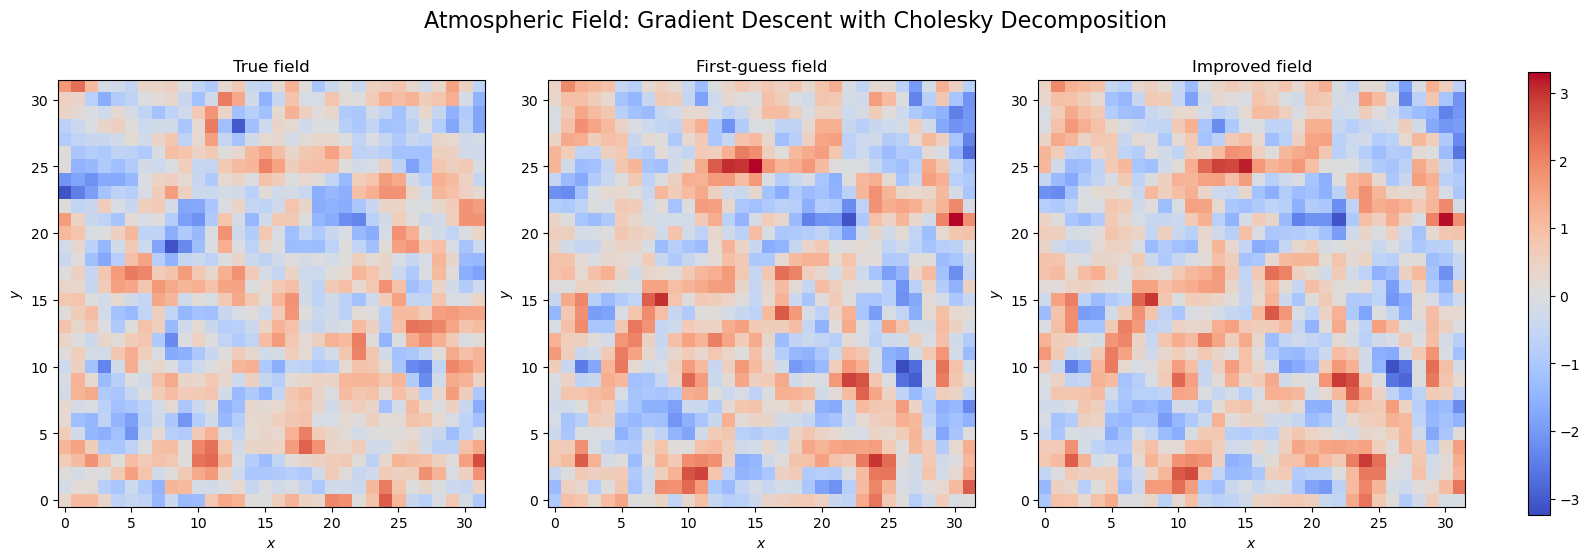

In [16]:
# Plot the true field, the first guess, and the improved field
f_optimized_cholesky = f_guess + f_adjust_cholesky
helper.plot_multi_heatmap_evolution([[f_true], [f_guess], [f_optimized_cholesky]], nr, nc,
                                    ['True field', 'First-guess field', 'Improved field'], None, 'Atmospheric Field: Gradient Descent with Cholesky Decomposition', 
                                    vmin=np.min([f_true, f_guess, f_optimized_cholesky]), vmax=np.max([f_true, f_guess, f_optimized_cholesky]))


Now, we want to be able to directly compare the two approaches.
- In order to make an apples-to-apples comparison, both gradient descent methods have to be using the same initialization, model, etc.

In [45]:
### Create a function that runs gradient descent and then cholesky gradient descent, while using the same ocean state observations for both

def compare_gd_methods_once(M, F, f_true, f_guess, C_control, C_error, 
                            x0, timesteps, 
                            ocean_states_observed, num_iters, step_size, 
                            methods, debug=False):
    """
    Run multiple methods of gradient descent on the same data.

    each method in methods is a list of the form
    ["Method Name", method_func, extra_params]
    Args:

    """
    results = {}

    for method_name, method_func, extra_params in methods:
        if debug:
            print(f"Running method {method_name}")

        f_adjust, losses = gradient_descent_template(M, F, f_true, f_guess, C_control, C_error, 
                                                     x0, timesteps, 
                                                     ocean_states_observed, num_iters, step_size,
                                                     method_func, extra_params, debug)
        results[method_name] = (f_guess, f_adjust, losses)

    return results


def compare_gd_methods_many_times(M, F, C_known, C_error, C_ocean, sigma, # World parameters
                                    timesteps, num_iters, step_size,        # Simulation and optimization parameters
                                    num_runs, methods, debug=False):        # Optimization
    """
    Create many different sets of data. Thus, we need to create a new f, x0, and ocean_states_observed for each run.
    For each one, we will run each of our gradient descent methods.
    Once we finish, we average losses across all runs.
    """
    C_control = C_known + C_error
    losses = {method[0]: 
                        {"ocean": [], "atmosphere": [], "control_adjust_mahalanobis": [], 
                         "Norm s": [], "Pre-dan  expected Delta J": [], "Post-dan expected Delta J": [], "Actual Delta J": [],
                         "Norm of Pre-dan step": [], "Norm of Post-dan step": [], "$(a_i \cdot u_i)/|u_i||a_i|$": [],
                         "$s^T C@ s $": [], "$a_i$": [],"$a_i^T s$": [], "$a_i^T (\delta Cs)$ Normalized": []}
              for method in methods}

    for i in range(num_runs):
        if debug:
            print(f"Run {i+1}/{num_runs}")
        # Create new simulation world
        f_true, f_guess = helper.generate_first_guess_field(C_known, C_error, nr, nc)
        x0 = helper.create_random_initial_ocean_state(nr, nc, C_ocean, num_circles=20, radius=5, values=[2,-2])[1]
        ocean_states_real = helper.compute_2d_affine_time_evolution(x0, M, F*f_true, range(timesteps), timesteps)
        ocean_states_observed = [helper.observe(ocean_states_real[i], sigma, num_obs_per_timestep) for i in range(timesteps)]

        # Place on a map
        ocean_states_observed = [helper.nan_map_observations(indices_t, observations_t, nr, nc) 
                            for indices_t, observations_t in ocean_states_observed]
        ocean_states_observed = [np.reshape(ocean_states_observed[i], (nr*nc,1)) for i in range(len(ocean_states_observed))]

        results = compare_gd_methods_once(M, F, f_true, f_guess, C_control, C_error, 
                                          x0, timesteps, ocean_states_observed, num_iters, step_size, methods, debug)
        
        # Store losses
        for method_name, (f_guess, f_adjust, losses_dict) in results.items():
            for loss_name, loss in losses_dict.items():
                losses[method_name][loss_name].append(loss)

    # Average losses along the runs axis
    # Preserve losses at each iteration
    for method_name, losses_dict in losses.items():
        for loss_name, loss_list in losses_dict.items():
            losses[method_name][loss_name] = np.mean(loss_list, axis=0)

    return losses
    
    

    

In [18]:
# Use function above to compute losses
methods = [
    ["Simple Gradient Descent", simple_gradient_step_compute, []],
    ["Cholesky Gradient Descent", cholesky_gradient_step_compute, []]
]

losses_many = compare_gd_methods_many_times(M, F, C_known, C_error, C_ocean, sigma, timesteps, num_iters, step_size, num_runs, methods, debug=True)

Run 1/1
Running method Simple Gradient Descent
Ocean loss at iteration 0: 46.258019348402605


C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:76: RuntimeWarning: invalid value encountered in scalar divide
  losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:78: RuntimeWarning: invalid value encountered in scalar divide
  losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )


Final loss: 37.82849179412693
Running method Cholesky Gradient Descent
Ocean loss at iteration 0: 46.258019348402605
Final loss: 40.36925309358469


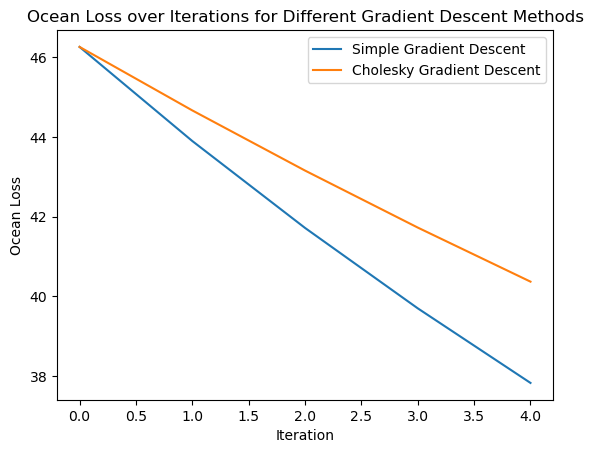

In [19]:
# Plot ocean loss over iterations
plt.figure()
for method_name, losses_dict in losses_many.items():
    plt.plot(losses_dict["ocean"], label=method_name)
plt.xlabel("Iteration")
plt.ylabel("Ocean Loss")
plt.legend()
plt.title("Ocean Loss over Iterations for Different Gradient Descent Methods")
plt.show()

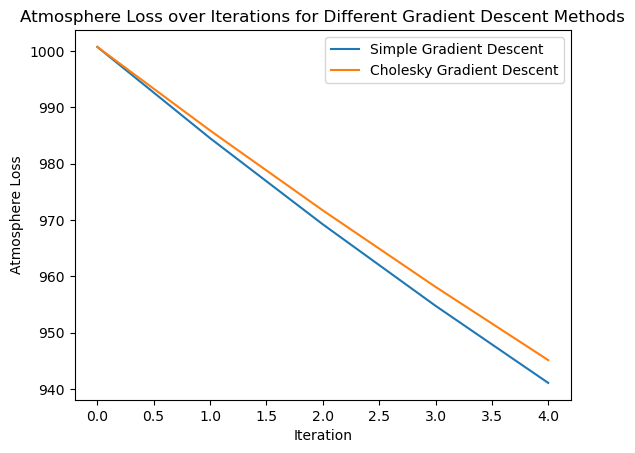

In [20]:
# Plot the atmosphere losses over iters for both methods
plt.figure()
for method_name, losses_dict in losses_many.items():
    plt.plot(losses_dict["atmosphere"], label=method_name)

plt.xlabel("Iteration")
plt.ylabel("Atmosphere Loss")
plt.legend()
plt.title("Atmosphere Loss over Iterations for Different Gradient Descent Methods")
plt.show()




### Add covariance enforcement to our loss function

We'll use our appended loss function:

$$J_{cov}(x, f) =
      J(x) +
      f^\top C^{-1} f$$

If we take the gradient:

$$\frac{d J_{cov}}{d f} = 
      \frac{d J}{d f} +
      2C^{-1} f$$

Our procedure is almost identical: we just add a term.

In [21]:

def covariance_control_adjust_step_compute(M, F, f_guess, f_adjust, C_control, C_error, 
                                    ocean_states_observed, ocean_states_simulated, step_size,
                                    weight): # Extra parameter
    """ 
    Compute the step for gradient descent with covariance term.
    
    Args:
        M: Model matrix
        F: Scalar constant for forcing
        f_guess: Initial guess for the atmospheric forcing field
        f_adjust: Adjustment to the atmospheric forcing field
        C_control: Covariance matrix for the control
        C_error: Covariance matrix for the control error
        ocean_states_observed: Observed ocean states
        ocean_states_simulated: Simulated ocean states
    
    weight is our extra parameter
    """
    f = f_guess + f_adjust

    dJdf = compute_dJ_df(M, F ,ocean_states_observed, ocean_states_simulated) #Gradient

    cov_loss_grad = 2 * np.linalg.inv(C_error) @ f_adjust # Covariance term
    dJ_df_cov = dJdf + weight * cov_loss_grad 

    norm_dJ_df_cov = dJ_df_cov * (np.linalg.norm(dJdf) / np.linalg.norm(dJ_df_cov)) # Rescale magnitude to match original
    step = -step_size * norm_dJ_df_cov
    return step

#Use template

def gradient_descent_covariance_control_adjust(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                                        x0, timesteps,                                   # Simulation parameters
                                        ocean_states_observed, num_iters, step_size,      # Optimization parameters
                                        weight, debug=False): # Optimization method
    return gradient_descent_template(M, F, f_true, f_guess, C_control, C_error, 
                                     x0, timesteps, 
                                     ocean_states_observed, num_iters, step_size,
                                     covariance_control_adjust_step_compute, [weight], debug)




# Run gradient descent with covariance term using above
weight = 0.1
step_size = 0.1

f_adjust_covariance_control_adjust, losses_covariance_control_adjust = gradient_descent_covariance_control_adjust(M, F, f_true, f_guess, C_control, C_error,
                                                                                                x0, timesteps, 
                                                                                                ocean_states_observed, num_iters, step_size, 
                                                                                                weight, debug=True)


Ocean loss at iteration 0: 48.00640893404933


C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:76: RuntimeWarning: invalid value encountered in scalar divide
  losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:78: RuntimeWarning: invalid value encountered in scalar divide
  losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )


Final loss: 43.082247926326914


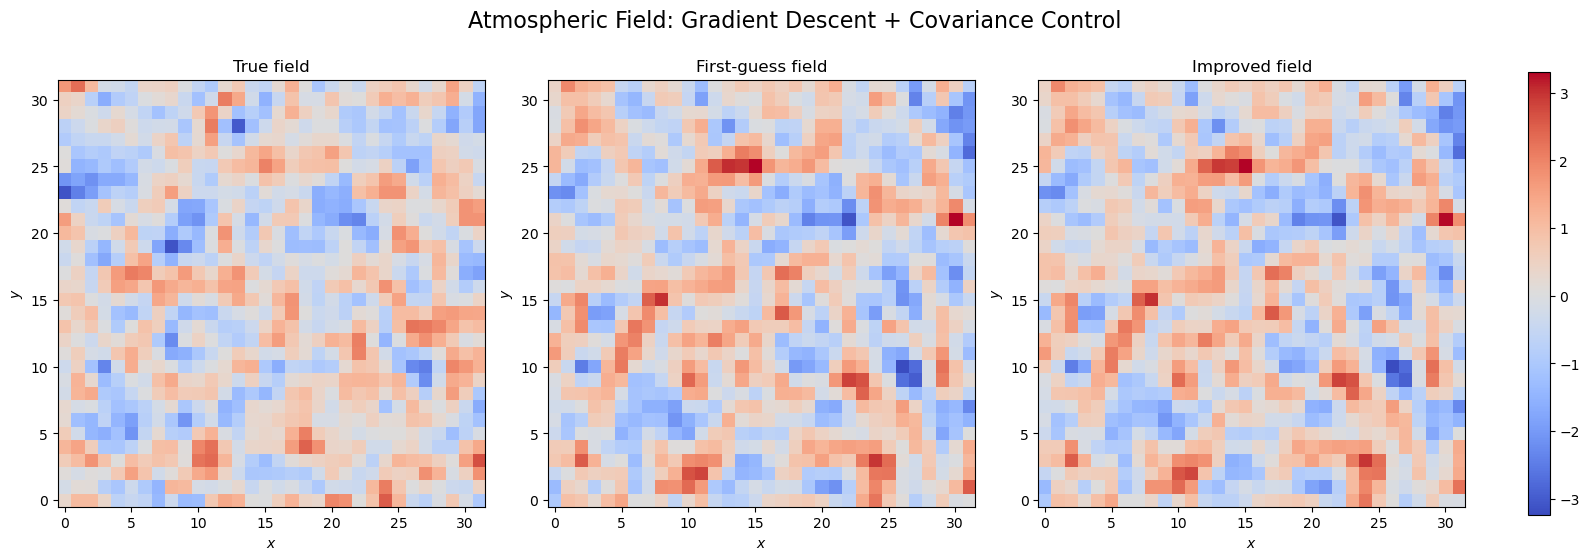

In [22]:
# Plot the true field, the first guess, and the improved field

f_improved_cov_control = f_guess + f_adjust_covariance_control_adjust

helper.plot_multi_heatmap_evolution([[f_true], [f_guess], [f_improved_cov_control]], nr, nc,
                                    ['True field', 'First-guess field', 'Improved field'], None, 'Atmospheric Field: Gradient Descent + Covariance Control', 
                                    vmin=np.min([f_true, f_guess, f_improved_cov_control]), vmax=np.max([f_true, f_guess, f_improved_cov_control]))

### Enforce Covariance after generating $dJ/df$

We start with a gradient of $dJ/df$. We want to take a step $u_i$ with some constraints:
- We want to shift the loss function by the same amount as before -- we'll call this quantity $\delta$. The original shift would have been  $(dJ/df)^\top(dJ/df)$.
  - The amount our loss function shifts is the dot product between our shift $u_i$, and the gradient $s=dJ/df$.

$$ \delta = u_i^\top s$$

- We want the covariance to be similar to $C$, the covariance, we expect. We implement this with our loss penalty, $u_I^\top C^{-1} u_i$.

We can combine these two requirements into a single function $J'$ for us to optimize over:

$$ J' = \lambda (q^\top s - \delta) + q^\top C^{-1} q$$

Where we enforce $dJ'/dq=0$, and $dJ/d\lambda=0$.

When we solve this, we find:

$$ q = \delta \frac{C s}{s^\top Cs}$$

Let's try this approach.


In [23]:


def dan_step_compute(M, F, f_guess, f_adjust, C_control, C_error, 
                                           ocean_states_observed, ocean_states_simulated,
                                           step_size): # Extra parameter
    """ 
    Compute the step for gradient descent with covariance applied to 
    
    Args:
        M: Model matrix
        F: Scalar constant for forcing
        f_guess: Initial guess for the atmospheric forcing field
        f_adjust: Adjustment to the atmospheric forcing field
        C_control: Covariance matrix for the control
        C_error: Covariance matrix for the control error
        ocean_states_observed: Observed ocean states
        ocean_states_simulated: Simulated ocean states
    
    weight is our extra parameter
    """
    dJdf = compute_dJ_df(M, F ,ocean_states_observed, ocean_states_simulated) #Gradient
    s = dJdf
    step_gd = -step_size * s
    delta = (step_gd).T @ s # Total change in J

    step = delta * (C_error @ s) / (s.T @ C_error @ s)

    return step    


def gradient_descent_dan(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                                        x0, timesteps,                                   # Simulation parameters
                                        ocean_states_observed, num_iters, step_size,      # Optimization parameters
                                        debug=False): # Optimization method
    return gradient_descent_template(M, F, f_true, f_guess, C_control, C_error, 
                                     x0, timesteps, 
                                     ocean_states_observed, num_iters, step_size,
                                     dan_step_compute, [], debug)
    

    
    

In [24]:
# Run gradient descent with covariance term
weight = 0.1
step_size = 0.1

f_adjust_dan, losses_dan = gradient_descent_dan(M, F, f_true, f_guess, C_control, C_error,
                                                                                                x0, timesteps,
                                                                                                ocean_states_observed, num_iters, step_size,
                                                                                                debug=True)



# Plot the true field, the first guess, and the improved field

f_improved_cov_gd_update = f_guess + f_adjust_dan



Ocean loss at iteration 0: 48.00640893404933


C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:76: RuntimeWarning: invalid value encountered in scalar divide
  losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:78: RuntimeWarning: invalid value encountered in scalar divide
  losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )


Final loss: 38.10984995594818


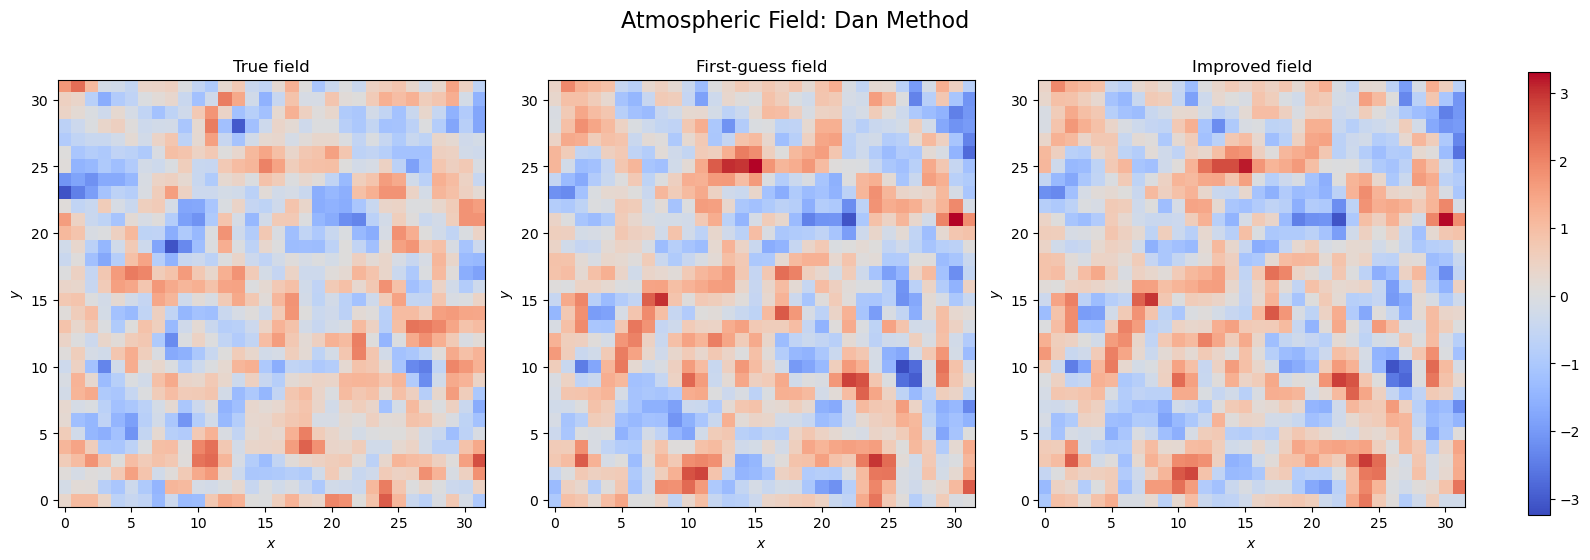

In [25]:
helper.plot_multi_heatmap_evolution([[f_true], [f_guess], [f_improved_cov_gd_update]], nr, nc,
                                    ['True field', 'First-guess field', 'Improved field'], None, 'Atmospheric Field: Dan Method', 
                                    vmin=np.min([f_true, f_guess, f_improved_cov_gd_update]), vmax=np.max([f_true, f_guess, f_improved_cov_gd_update]))


In [26]:
num_runs = 1
F = 0.1
timesteps = 10
num_iters = 100
step_size = 0.1
num_obs_per_timestep = 10
weight = 0.01

# Compare all four methods

methods = [
    #['Simple ($u_i \propto - $'r'$\nabla_f \,J$)', simple_gradient_step_compute, []],
    #['Control-$a_i$ ($u_i \propto - $'r'$(\cdot \nabla_f \,J +2C^{-1} a_i) $)',covariance_control_adjust_step_compute, [weight]],
    ["Dan Method", dan_step_compute, []]
]

#losses_many = compare_gd_methods_many_times(M, F, C_known, C_error, C_ocean, sigma, timesteps, num_iters, step_size, num_runs, methods, debug=True)

# Include four subplots, one for each loss type






In [27]:
def get_mahalanobis(f, C):
    return np.linalg.norm(f.T @ np.linalg.inv(C) @ f)



def plot(losses_many):

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    loss_funcs = ["$\sum_t (Ex(t)-y(t))^{T} (Ex(t)-y(t))$", "$\sum_t (f_i(t)-f_{true}(t) )^{T} ( f_i(t)-f_{true}(t) )$", "$a_i^T C^{-1}_{err} a_i$"]



    for i, (loss_name, ax, func) in enumerate(zip(["ocean", "atmosphere", "control_adjust_mahalanobis"], axs.flatten(), loss_funcs)):
        for method_name, losses_dict in losses_many.items():
            ax.plot(losses_dict[loss_name], label=method_name)
        ax.set_xlabel("Iteration $i$")
        ax.set_ylabel(loss_name+" loss:    "+func)
        ax.legend()
        ax.set_title(f"{loss_name}: "+func)

    # Fourth plot: ocean + control_adjust_mahalanobis if using covariance control adjust, just ocean otherwise

    ax = axs[1, 1]
    for method_name, losses_dict in losses_many.items():
        if method_name == r"Control-$a_i$ ($u_i \propto - $$(\cdot \nabla_f \,J +2C^{-1} a_i) $)":
            print('TEST')
            ax.plot(losses_dict["ocean"] + losses_dict["control_adjust_mahalanobis"], label=method_name)
        else:
            print(method_name)
            ax.plot(losses_dict["ocean"], label=method_name)

    ax.set_xlabel("Iteration $i$")
    ax.set_ylabel("J'")
    ax.legend()
    ax.set_title("J'")


    fig.suptitle(f"Gradient Descent Variants: num_obs={num_obs_per_timestep}, step_size={step_size}, time_steps={timesteps}, num_iters={num_iters}, "r"$\alpha=$"f"{weight}")



    plt.tight_layout()
    plt.show()

#plot(losses_many)

# Regularize $dJ/df$, then apply covariance afterwards

In our comparison, we saw that the version where we covariance-constrain the control adjustment, generally worked best.

- But in the long run, it tends to overfit.

On the other hand, the model where we covariance-constrain the entire control, doesn't learn as well, but it does avoid overfitting.

- This may be because the covariance constraint $q^\top C^{-1} q$ acts to *regularize*, as well as encouraging $q$ to have covariance $C$.

We already have a way to enforce the covariance, so we just need the regularization: rather than adding $q^\top C^{-1} q$, we instead add $q^\top I q = q^\top q$.

We'll see the results when we combine both.

In [28]:
def dan_regularized_control_step_compute(M, F, f_guess, f_adjust, C_control, C_error,
                                    ocean_states_observed, ocean_states_simulated, step_size,
                                    weight): # Extra parameter
    """ 
    Compute the step for gradient descent with regularization and covariance applied to the control adjustment.
    
    Args:
        M: Model matrix
        F: Scalar constant for forcing
        f_guess: Initial guess for the atmospheric forcing field
        f_adjust: Adjustment to the atmospheric forcing field
        C_control: Covariance matrix for the control
        C_error: Covariance matrix for the control error
        ocean_states_observed: Observed ocean states
        ocean_states_simulated: Simulated ocean states
    
    weight is our extra parameter
    """
    f = f_guess + f_adjust

    dJdf = compute_dJ_df(M, F ,ocean_states_observed, ocean_states_simulated) #Gradient
    regularizer = 2 * f

    s = dJdf + weight * regularizer
    
    step_gd = -step_size * s
    delta = (step_gd).T @ s # Total change in J

    step = delta * (C_error @ s) / (s.T @ C_error @ s)

    return step

def gradient_descent_dan_regularized_control_regularized(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                                        x0, timesteps,                                   # Simulation parameters
                                        ocean_states_observed, num_iters, step_size,      # Optimization parameters
                                        weight, debug=False): # Optimization method
    """
    Perform gradient descent with covariance control adjustment and regularization.
    """
    return gradient_descent_template(M, F, f_true, f_guess, C_control, C_error, 
                                     x0, timesteps, 
                                     ocean_states_observed, num_iters, step_size,
                                     dan_regularized_control_step_compute, [weight], debug)


                                                               

In [29]:
def dan_modified_step_compute(M, F, f_guess, f_adjust, C_control, C_error, 
                                           ocean_states_observed, ocean_states_simulated,
                                           step_size): # Extra parameter
    """ 
    Compute the step for gradient descent with covariance applied to 
    
    Args:
        M: Model matrix
        F: Scalar constant for forcing
        f_guess: Initial guess for the atmospheric forcing field
        f_adjust: Adjustment to the atmospheric forcing field
        C_control: Covariance matrix for the control
        C_error: Covariance matrix for the control error
        ocean_states_observed: Observed ocean states
        ocean_states_simulated: Simulated ocean states
    
    weight is our extra parameter
    """
    dJdf = compute_dJ_df(M, F ,ocean_states_observed, ocean_states_simulated) #Gradient
    s = dJdf

    step_gd = -step_size * s
    delta = s.T @(step_gd) # Total change in J
    
    step = -f_adjust + (delta + s.T @ f_adjust) * (C_error @ s) / (s.T @ C_error @ s )
    return step    


def gradient_descent_dan_modified(M, F, f_true, f_guess, C_control, C_error,       # World parameters
                                        x0, timesteps,                                   # Simulation parameters
                                        ocean_states_observed, num_iters, step_size,      # Optimization parameters
                                        debug=False): # Optimization method
    return gradient_descent_template(M, F, f_true, f_guess, C_control, C_error, 
                                     x0, timesteps, 
                                     ocean_states_observed, num_iters, step_size,
                                     dan_modified_step_compute, [], debug)
    

# Descent 

In [49]:
1

1

In [109]:
# Run many gradient descents
num_runs = 1
F = 0.1
timesteps = 5              
num_iters = 10
step_size = .01
num_obs_per_timestep = 10  
weight = 0.2               

methods = [
    ['Simple ($u_i \propto - $'r'$\nabla_f \,J$)', simple_gradient_step_compute, []],
    ['Line Search', golden_mean_line_search, []],
    #['Cholesky Gradient Descent', cholesky_gradient_step_compute, []],
    #['Control-$a_i$ ($u_i \propto - $'r'$(\cdot \nabla_f \,J +2C^{-1} a_i) $)', covariance_control_adjust_step_compute, [weight]],
    #["Dan Method", dan_step_compute, []],
    #["Dan Method Modified", dan_modified_step_compute, []],
    #["Dan Method + Control Regularization", dan_regularized_control_step_compute, [weight]]
]


losses_many = compare_gd_methods_many_times(M, F, C_known, C_error, C_ocean, sigma, timesteps, num_iters, step_size, num_runs, methods, debug=True)




Run 1/1
Running method Simple ($u_i \propto - $$\nabla_f \,J$)
Ocean loss at iteration 0: 2.192981533692357


C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:76: RuntimeWarning: invalid value encountered in scalar divide
  losses["$a_i^T (\delta Cs)$ Normalized"].append( (f_adjust.T @  (delta * C_error @ s))[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(delta * C_error @ s)) )
C:\Users\ruizshau\AppData\Local\Temp\ipykernel_15012\2947118222.py:78: RuntimeWarning: invalid value encountered in scalar divide
  losses["$(a_i \cdot u_i)/|u_i||a_i|$"].append( (f_adjust.T @ post_dan_step)[0,0] / (np.linalg.norm(f_adjust) * np.linalg.norm(post_dan_step)) )


Final loss: 2.157303450079892
Running method Line Search
Ocean loss at iteration 0: 2.192981533692357
beging GMLS  0.0061803398874989484 0.016180339887498948
initial search for the bound 0.0061803398874989484 0.01 0.016180339887498948
initial search for the bound 149.12449591662482 149.12290581353884 149.1203345671489
sliding right
intermediate search for the bound 0.01 0.016180339887498948 0.02618033988749895
intermediate search for the bound 149.12290581353884 149.1203345671489 149.11617837741767
bound to the right
sliding right
intermediate search for the bound 0.016180339887498948 0.02618033988749895 0.0423606797749979
intermediate search for the bound 149.1203345671489 149.11617837741767 149.1094644496835
bound to the right
sliding right
intermediate search for the bound 0.02618033988749895 0.0423606797749979 0.06854101966249684
intermediate search for the bound 149.11617837741767 149.1094644496835 149.09862969763435
bound to the right
sliding right
intermediate search for the bou

Simple ($u_i \propto - $$\nabla_f \,J$)
Line Search


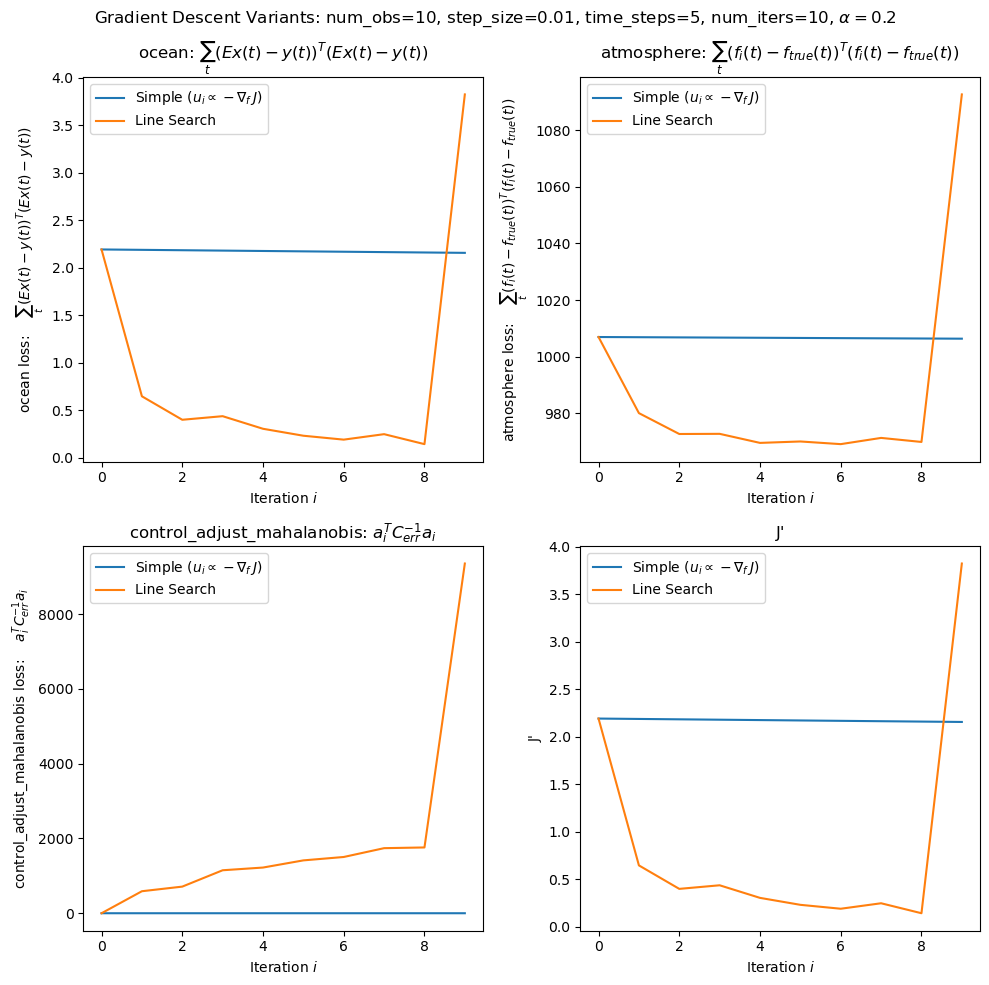

In [110]:
plot(losses_many)

In [ ]:
# Create a function which plots 
# s, delta = s^T (step_size*s), s^T u, Delta J, s' 
# On 5 subplots

def plot_dan(losses_many, k1,k2,tickwidth):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))

    #,"$a_i^T (\delta Cs)$ Normalized"
    #, "$a_i^T s$"
    for i, (loss_name, ax) in enumerate(zip(
                                            ["ocean", "Norm s", "Pre-dan  expected Delta J",  
                                             "Norm of Pre-dan step", "Norm of Post-dan step","$(a_i \cdot u_i)/|u_i||a_i|$",
                                             "Post-dan expected Delta J", "Actual Delta J" ], axs.flatten())):
        for method_name, losses_dict in losses_many.items():
            ax.plot(range(k1, k2), losses_dict[loss_name][k1:k2], ".-", label=method_name)
        ax.set_xlabel("Iteration $i$")
        ax.set_ylabel(loss_name)
        ax.legend()
        ax.set_title(f"{loss_name}")
        ax.grid(True)
        
        # Set x-axis ticks to reflect the actual iteration numbers
        ax.set_xticks(range(k1, k2, tickwidth))
        ax.set_xticklabels(range(k1, k2, tickwidth))

    fig.suptitle(f"Gradient Descent Variants: num_obs={num_obs_per_timestep}, step_size={step_size}, time_steps={timesteps}, num_iters={num_iters}, "r"$\alpha=$"f"{weight}")

    #Add a 9th plot:
    # subtract expected delta J post-dan vs actual
    ax = axs[2, 2]
    for method_name, losses_dict in losses_many.items():
        ax.plot(range(k1, k2), 
                ( losses_dict["Post-dan expected Delta J"][k1:k2] - losses_dict["Actual Delta J"][k1:k2])**2,
                  ".-", label=method_name)
    ax.set_xlabel("Iteration $i$")
    ax.set_ylabel("Delta J")
    ax.legend()
    ax.set_title("(Post-dan expected Delta J - Actual Delta J)^2")
    ax.grid(True)

    # Set x-axis ticks to reflect the actual iteration numbers
    ax.set_xticks(range(k1, k2, tickwidth))
    ax.set_xticklabels(range(k1, k2, tickwidth))

    plt.tight_layout()
    plt.show()



def plot_dan_2(losses_many, k1,k2, tickwidth):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    for method_name, losses_dict in losses_many.items():
        #Ignore simple gradient descent 
        if method_name != 'Simple ($u_i \propto - $'r'$\nabla_f \,J$)':
            continue
        ax.plot(range(k1, k2), losses_dict["Pre-dan  expected Delta J"][k1:k2], "o-", label="Pre-dan")
        ax.plot(range(k1, k2), losses_dict["Post-dan expected Delta J"][k1:k2], ".-", label="Post-dan")
        ax.plot(range(k1, k2), losses_dict["Actual Delta J"][k1:k2], ".-", label="Actual")

    ax.set_xlabel("Iteration $i$")
    ax.set_ylabel("Delta J")
    ax.legend()
    ax.set_title("Delta J Comparison")
    ax.grid(True)

    # Set x-axis ticks to reflect the actual iteration numbers
    ax.set_xticks(range(k1, k2, tickwidth))
    ax.set_xticklabels(range(k1, k2, tickwidth))

    fig.suptitle(f"Gradient Descent Variants: num_obs={num_obs_per_timestep}, step_size={step_size}, time_steps={timesteps}, num_iters={num_iters}, "r"$\alpha=$"f"{weight}")

    plt.tight_layout()
    plt.show()

#Separate plot
k1,k2 = 94,104
tickwidth = 1
#k1,k2 = 0, num_iters
plot_dan(losses_many, k1,k2, tickwidth)
plot_dan_2(losses_many, k1,k2, tickwidth)



In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your data is in the shape (n_samples, n_features, n_dimensions)
# We need to reshape it to (n_samples, n_features * n_dimensions)

dan_mod_label = "Dan Method Modified"
simple_label = 'Simple ($u_i \propto - $'r'$\nabla_f \,J$)'
dan_label = "Dan Method"
line_label = "Line Search"

vector_list = losses_many[simple_label]["$a_i$"]
# Step 1: Reshape the data
data = np.array(vector_list)
n_samples, n_features, n_dimensions = data.shape
data_reshaped = data.reshape(n_samples, -1)

# Step 2: Perform PCA
pca = PCA()
pca.fit(data_reshaped)

# Step 3: Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Step 5: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Step 6: Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Step 7: Determine the number of components needed to explain a certain percentage of variance
target_variance = 0.95  # for example, 95% of variance
n_components = np.argmax(cumulative_variance_ratio >= target_variance) + 1
print(f"Number of components needed to explain {target_variance*100}% of variance: {n_components}")

# Step 8: Print the magnitude (explained variance ratio) of each component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Component {i+1}: {ratio:.4f}")

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Assuming your a_i terms are stored in a list called 'a_i_list'

# Step 1: Prepare the data
data = vector_list
n_samples, n_features, n_dimensions = data.shape
data_reshaped = data.reshape(n_samples, -1)

# Step 2: Perform PCA and transform the data to the first two principal components
pca = PCA(n_components=2)
a_i_compressed = pca.fit_transform(data_reshaped)

# Step 3: Create a custom colormap for the gradient
colors = ['blue', 'green', 'yellow', 'red']
n_bins = 100  # Number of color gradations
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Step 4: Plot the compressed data points with connecting lines and color gradient
plt.figure(figsize=(12, 8))

for i in range(len(a_i_compressed) - 1):
    plt.plot(a_i_compressed[i:i+2, 0], a_i_compressed[i:i+2, 1], 
             color=cmap(i / (len(a_i_compressed) - 1)), 
             linewidth=2)

# Add scatter plot on top to emphasize data points
scatter = plt.scatter(a_i_compressed[:, 0], a_i_compressed[:, 1], 
                      c=range(len(a_i_compressed)), cmap=cmap, 
                      s=50, zorder=10)

plt.colorbar(scatter, label='Iterations')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('a_i Terms Compressed to First Two Principal Components')
plt.grid(True)

# Annotate some points (e.g., start, middle, end) for better understanding
plt.annotate('Start', (a_i_compressed[0, 0], a_i_compressed[0, 1]), 
             xytext=(5, 5), textcoords='offset points')
plt.annotate('End', (a_i_compressed[-1, 0], a_i_compressed[-1, 1]), 
             xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Print the explained variance ratio for the first two components
print(f"Explained variance ratio of the first two components: {pca.explained_variance_ratio_}")